In [7]:
import numpy as np
from numpy.random import uniform, exponential
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style='whitegrid')
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [3]:
pd.options.display.max_columns = 100

<div style="background-color:#9f5f80;
            border-radius:10px;
            border:3px solid #583d72;
            padding: 5px;
            display: inline-block;
            ">
    A <b>very</b> detailed tutorial is available in the <a href="https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html">lifelines docs</a> - the library used for survival analysis here. It goes into much more depth and shows more complex models available in the library along with theoretical explanations. 
</div>
</br>
</br>

In this notebook we will real data from a telco churn usecase to see how survival analysis can help us build informative explanatory and predictive models. 

# Load dataset

In [4]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = np.where(df['TotalCharges'].str.strip()=='', np.nan, df['TotalCharges']).astype(float)
df['Churn'] = df['Churn'] == 'Yes'
df.dropna(inplace=True)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,False
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,True


The [dataset](https://www.kaggle.com/blastchar/telco-customer-churn) is from Kaggle. It contains mostly categorical variables describing demographics of customers. 

Critically for us, the `tenure` and `Churn` is available. Let's take a look at our data.

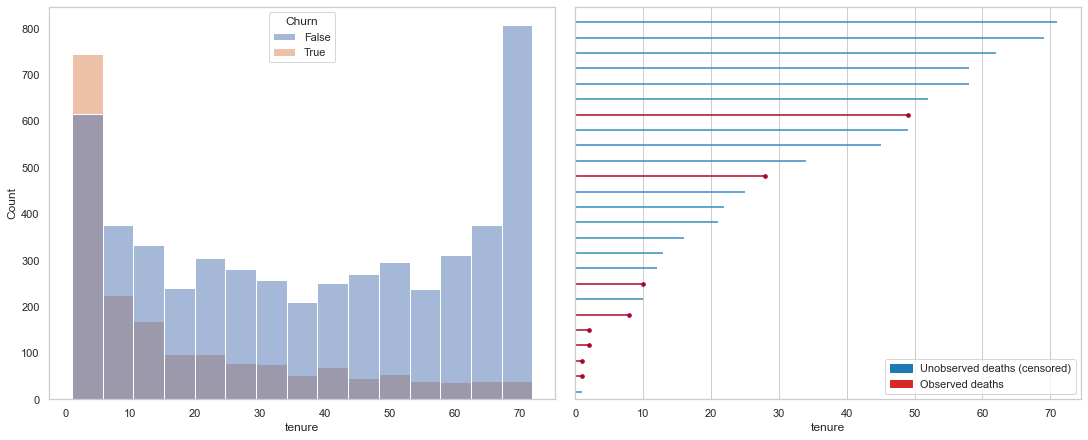

In [9]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,6), constrained_layout=True)

# sns.kdeplot(data=df, x='tenure', hue='Churn', shade=True, ax=ax1)
sns.histplot(data=df, x='tenure', hue='Churn', ax=ax1)
ax1.grid(False)

plot_lifetimes(df.iloc[:25]['tenure'], event_observed=df.iloc[:25]['Churn'], ax=ax2)
blue_patch = mpatches.Patch(color='tab:blue', label='Unobserved deaths (censored)')
red_patch = mpatches.Patch(color='tab:red', label='Observed deaths')
ax2.legend(handles=[blue_patch,red_patch], loc='lower right')
ax2.grid(False, axis='y')
ax2.set_yticklabels('');
ax2.set_xlabel("tenure");

The plot on the left shows the distribution of tenures for churners and non-churners. The orange distribution makes sense - it is a basic exponential decay-style curve. The blue curve is **zero-inflated** because of new customers who have *not churned so far* but have not been eligible to churn for long. 

Same story is seen on the right where blue lines are censored events (we have limited data for these customers) and red lines are true churners. 

Try to think of the difference between the top-most and bottom-most blue lines. They are both non-churners but are very different: one is a brand new customer who could churn tomorrow, the other is a loyal old customer. 

Also, compare this to the dummy scenario in the previous notebook. Here we don't have 'actual lifetimes' and only 'observed lifetimes' (`tenure`).

# Survival function

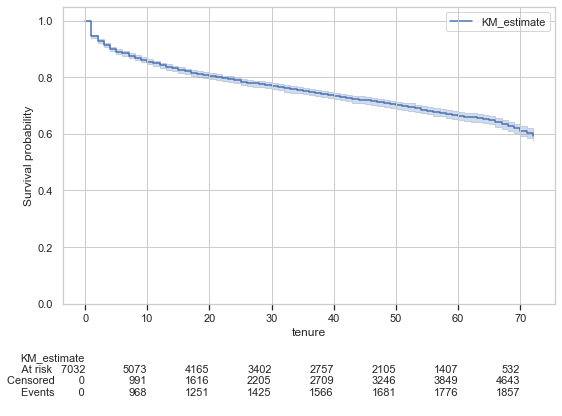

In [44]:
kmf = KaplanMeierFitter()
kmf.fit(df['tenure'], event_observed=df['Churn'])

ax = kmf.plot_survival_function(at_risk_counts=True, figsize=(8,6))
ax.set(xlabel='tenure', ylabel='Survival probability', ylim=(0,1.05));

The survival probability doesn't go below 60% when we fit the curve to the whole customer base. It's pretty tempting to say that this customer base is healthy and is not leaking customers. 

Is this really true though?

In [22]:
def survival_breakdown(df, col_name, zero_yaxis=False, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,4.5))
    ax.set_title(f"Lifespans of different {col_name}")
    
    for grp, grp_df in df.groupby(col_name):
        kmf = KaplanMeierFitter()
        kmf.fit(grp_df['tenure'], event_observed=grp_df['Churn'], label=grp)
        kmf.plot_survival_function(ax=ax)
        ax.set(xlabel='tenure', ylabel='Survival Probability')
        if zero_yaxis:
            ax.set_ylim(0,1.05)
    return ax

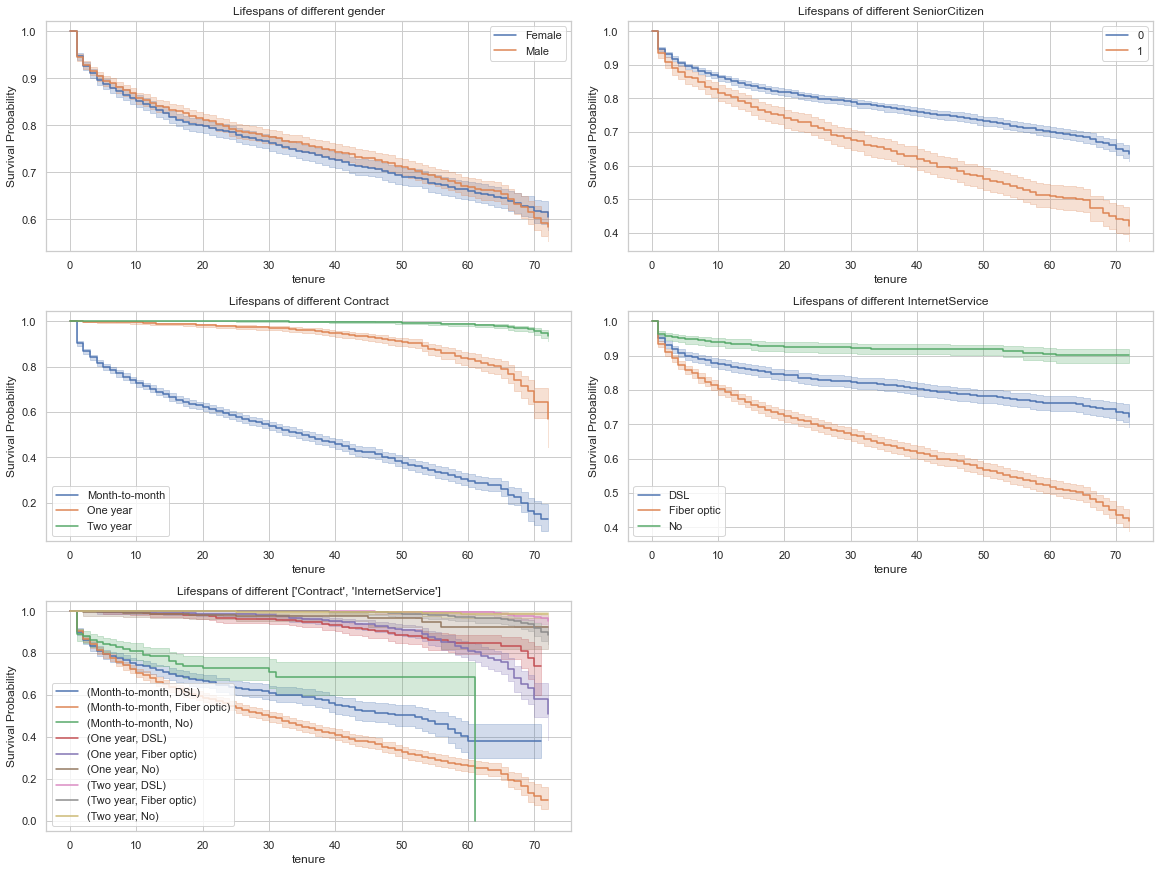

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16,12), constrained_layout=True)
axes = axes.flatten()

survival_breakdown(df, 'gender', ax=axes[0]);
survival_breakdown(df, 'SeniorCitizen', ax=axes[1]);
survival_breakdown(df, 'Contract', ax=axes[2]);
survival_breakdown(df, 'InternetService', ax=axes[3]);
survival_breakdown(df, ['Contract','InternetService'], ax=axes[4]);
axes[5].remove();

*Keep in mind the y-axes of all plots are independant so be careful while making comparisons across plots*

Let's make grouped survival curves by some demographics. 

- Gender has no differentiation and there is only minor differentiation in senior citizen as well. 
- For contract type the monthly customers have a significantly lower survival probability throughout their tenure. 
    - This makes sense to me as this just describes the nature of the monthly product. 
    - Also, the other two contract types are very healthy (apart from a strange dip near the end for the 1 year version - may need to investigate).
- The internet service variable is more interesting. Having a better home internet leads to a significantly lower survival probability.
    - This effect is extreme for users of fiber internet. Unless huge majority of the customer base is core WiFi users this might be indicative of something problematic happening.
- As an extra step let's see if there is any interaction between internet and contract types.
    - It seems that fiber users who have yearly contracts are pretty healthy. The monthly contract has a muvh higher effect. 


**Possible hypothesis to explore:** Fiber internet users get a monthly account with the telco to 'fill gap in usage' or while travelling.

# Cox Regression

So far we have only looked at building explanatory models using survival analysis but there are predictive methods in this domain as well. *Cox regression* is a commonly used model. Head over to the [documentation/tutorial](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html) if you want to know the details or want to see more complex survival predictive models.  

For the mathematically inclined this regression is a trick using an exponential link function:

$$\log h(t) = \alpha + \beta X$$
$$h(t) = \exp ( \alpha + \beta X )$$
where $h(t)$ is the hazard function.

Like other ML models we need to encode the categorical variables into numbers. 

In [10]:
enc = OrdinalEncoder(dtype=int)
cat_cols = df.select_dtypes('O').drop('customerID', axis=1).columns
df_proc = df.copy()
df_proc[cat_cols] = enc.fit_transform(df_proc[cat_cols])
df_proc.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,False
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,False
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,True
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,False
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,True


The usual train/test split.

In [13]:
df_train, df_test = train_test_split(df_proc, test_size=0.2, random_state=42)

Again, same interface for building models. Here we use patsy-style formulas to specify the regression which is only using 2 variables:
$$S(t) = \beta_1 InternetService + \beta_2 Contract + \beta_3 (InternetService * Contract)$$

In [14]:
cph = CoxPHFitter()
cph.fit(df_train.drop('customerID', axis=1), 
        duration_col='tenure', event_col='Churn',
        formula='InternetService + Contract + InternetService * Contract')

<lifelines.CoxPHFitter: fitted with 5625 total observations, 4130 right-censored observations>

We can get a statistical summary of the model to check goodness-of-fit (concordance index) and explore the learned coefficients etc. 

In [15]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5625 total observations, 4130 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 5625
number of events observed = 1495
   partial log-likelihood = -11116.87
         time fit was run = 2021-04-27 10:19:19 UTC

---
                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                        
Contract                  -2.07       0.13       0.10            -2.26            -1.88                 0.10                 0.15
InternetService            0.09       1.09       0.05            -0.00             0.18                 1.00                 1.20
Contract:InternetService  -0.14       0.87       0.09            -0.32             0.03                 0.73                 1.03

                              z      p   -log2(p)
covariate                                        
Contract                 -21.16 <0.005     327.71
InternetService            1.90   0.06       4.13
Contract:InternetService  -1.62   0.11       3.25
---
Concordance = 0.78
Partial AIC = 22239.75
log-likelihood ratio test = 2142.33 on 3 df
-log2(p) of ll-ratio test = inf

Let's get predictions for the test set. 

Each line in the plot is a single customer. It looks like there are 3 distinct groups (based on our earlier exploration these look like the 3 contract types). 

<AxesSubplot:>

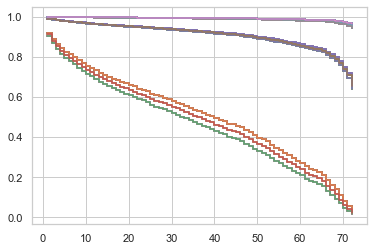

In [16]:
preds = cph.predict_survival_function(df_test.drop('customerID', axis=1))
preds.plot.line(drawstyle='steps-post', legend=False)

Let's isolate the lowest performing group and do a quick check. 

In [17]:
poor_performers_idx = preds.columns[preds.loc[70] < 0.2]
poor_performers = df.loc[poor_performers_idx]
len(poor_performers)

788

Like we guesed these are all monthly customers with majority fiber users. 

In [19]:
poor_performers['Contract'].value_counts()

Month-to-month    788
Name: Contract, dtype: int64

In [18]:
poor_performers['InternetService'].value_counts()

Fiber optic    437
DSL            254
No              97
Name: InternetService, dtype: int64

Let's do a visual check of how well we predicted these customers.

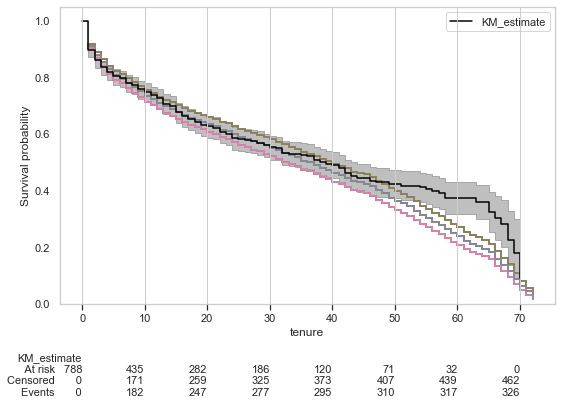

In [47]:
fig, ax = plt.subplots(figsize=(8,6))

preds[preds.columns[preds.loc[70] < 0.2]].plot.line(drawstyle='steps-post', legend=False, ax=ax)

kmf = KaplanMeierFitter()
kmf.fit(poor_performers['tenure'], event_observed=poor_performers['Churn'])
kmf.plot_survival_function(at_risk_counts=True, color='black', ax=ax)

ax.grid(False)
ax.set(xlabel='tenure', ylabel='Survival probability', ylim=(0,1.05));

In this plot the black line is survival curve fitted to these customers using their churn labels (ground truth data) and the other lines are predicted curved for each individual customer. 

The predictions are pretty spot on mostly but they underestimate the survival probability near the end:
- This could be because of random train/test split so cross validation is probably a good idea.
- Also, we can introduce regularization to the regression model to tweak this estimate and maybe overestimate rather than underestimate (if that is more appropriate for our usecase).
- Statistical metrics are also available to check goodness-of-fit rather than doing visual inspection. 

# Customer Lifetime Value

Apart from using the survival models themselves for explanatory or predictive purposes their results can be used in more complex downstream analyses. Here we see a toy example of customer lifetime value.

Our model for lifetime value is:
$$LTV = \text{AVG_Lifetime} * \text{AVG_order_size} * \text{AVG_num_orders}$$

Using predicted median lifetime for each customer and order value and count numbers we can get a unique customer value for all of them. 

In [87]:
# for the nan customers their survival probability never goes below 50% so median is not defined
median_lifetimes = pd.Series(np.where(preds.min() <= 0.5, (preds <= 0.5).idxmax(), np.nan))
(median_lifetimes
 .value_counts(dropna=False, normalize=True)
 .sort_index()
)

33.0    0.068941
36.0    0.310590
40.0    0.180526
NaN     0.439943
dtype: float64

In this example we are using separate order averages for each customer. We can use global (or segment-wise) averages instead. 

In [88]:
# these both can be obtained from historical data for estimation
avg_order_size = exponential(4000, len(median_lifetimes))
avg_num_orders = exponential(10, len(median_lifetimes))

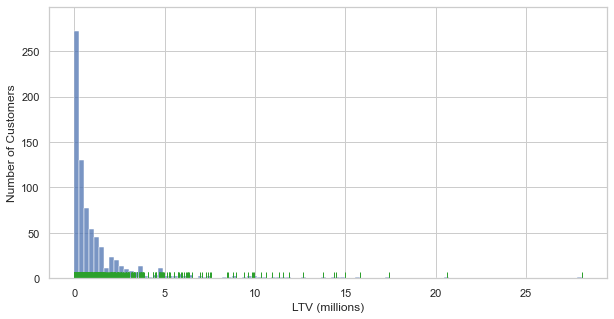

In [103]:
LTV = (median_lifetimes * avg_order_size * avg_num_orders) / 1e6

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(LTV, ax=ax)
sns.rugplot(LTV, color='tab:green',  ax=ax)
ax.set(xlabel='LTV (millions)', ylabel='Number of Customers');

This is a *very* simple LTV model that can be created relatively quickly. We can expand this by making the averages more sophisticated and maybe even using the full survival curve instead of the median value. 

There is even a separate python packge `lifetimes` which is designed for LTV calculations using full RFM models which include cash flow discounts etc. 